# Automatic road extraction using deep learning

- 🔬 Data Science
- 🥠 Deep Learning and pixel-based classification

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Area-of-Interest-and-data-pre-processing" data-toc-modified-id="Area-of-Interest-and-data-pre-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Area of Interest and data pre-processing</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Visualization-of-prepared-data" data-toc-modified-id="Visualization-of-prepared-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualization of prepared data</a></span></li><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training the model</a></span></li><li><span><a href="#Visualization-of-results" data-toc-modified-id="Visualization-of-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualization of results</a></span></li><li><span><a href="#Saving-the-trained-model" data-toc-modified-id="Saving-the-trained-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Saving the trained model</a></span></li><li><span><a href="#Inference-using-the-trained-model,-in-ArcGIS-Pro" data-toc-modified-id="Inference-using-the-trained-model,-in-ArcGIS-Pro-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Inference using the trained model, in ArcGIS Pro</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Introduction

Road network is a required layer in a lot of mapping exercises, for example in Basemap preparation <i>(critical for navigation)</i>, humanitarian aid, disaster management, transportation, and for a lot of other applications it is a critical component. 

This sample shows how ArcGIS API for Python can be used to train a deep learning model <i>(Multi-Task Road Extractor model)</i> to extract the road network from satellite imagery. The models trained can be used with ArcGIS Pro or ArcGIS Enterprise and even support distributed processing for quick results.


Further details on the Multi-Task Road Extractor implementation in the API (working principle, architecture, best practices, etc.), can be found in the Guide, along with instructions on how to set up the Python environment.

Before proceeding through this notebook, it is advised to go through the API Reference for Multi-Task Road Extractor (`prepare_data()`, `MultiTaskRoadExtractor()`). It will help in understanding the Multi-Task Road Extractor's workflow in detail.


_**Objectives:**_

<ol style="list-style-type:upper-roman">
<li>Classify roads, utilizing API's Multi-Task Road Extractor model.</li>
</ol>

## Area of Interest and data pre-processing

For this sample, we will be using a subset of the publically available <a href="https://spacenet.ai/spacenet-roads-dataset/" target="_blank">SpaceNet dataset</a>. Vector labels as _'road centerlines'_ are available for download along with imagery, hosted on _AWS S3_ <a href="#References">[1]</a>.

The area of interest is Paris, with 425 km of _'road centerline'_ length <i>(As shown in Figure. 1)</i>. Both of these inputs, Imagery, and vector layer <i>(for creating image chips and labels as 'classified tiles')</i> are used to create data that is needed for model training.

<p align="center">
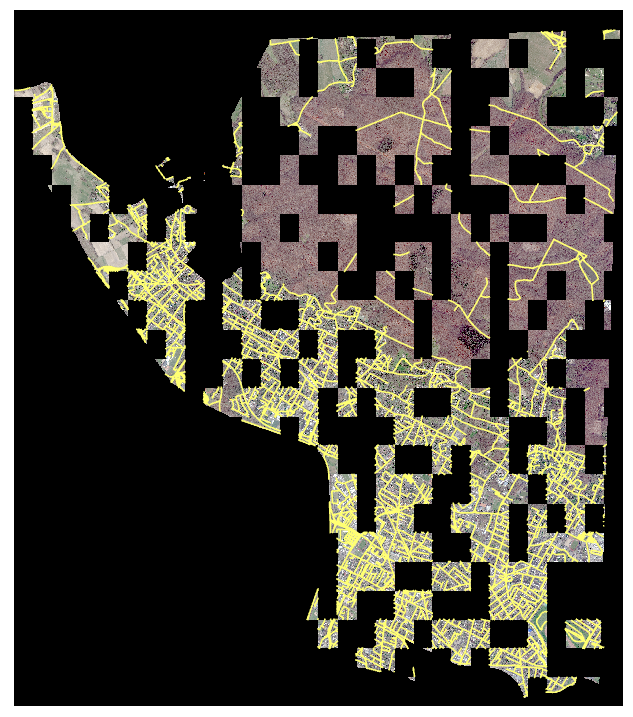
</p>

<center>Figure 1: SpaceNet dataset - AOI 3 - Paris</center>

Downloaded data has 4 types of imagery: Multispectral, Pan, Pan-sharpened Multispectral, Pan-sharpened RGB. 8-bit RGB imagery support and 16-bit RGB imagery experimental support is available with Multi-Task Road Extractor Model _(Multispectral imagery will be supported in the subsequent release)_. In this sample, Pan-sharpened RGB is used, after converting it to 8-bit imagery.

_**Pre-processing steps:**_


- Downloaded vector labels, in _`.geojson`_ format, are converted to _`feature class/shapefile`_. <i>(Refer to ArcGIS Pro's  <a href="https://pro.arcgis.com/en/pro-app/tool-reference/conversion/json-to-features.htm" target="_blank">JSON To Features GP tool.</a>)</i>


- The converted vector data is checked and repaired if any invalid geometry is found. <i>(Refer to ArcGIS Pro's  <a href="https://pro.arcgis.com/en/pro-app/tool-reference/data-management/repair-geometry.htm" target="_blank">Repair Geometry GP tool.</a>)</i>


- 'Stretch function' is used to convert 16-bit imagery to 8-bit imagery. <i>(Refer to ArcGIS Pro's  <a href="https://pro.arcgis.com/en/pro-app/help/data/imagery/stretch-function.htm" target="_blank">Stretch raster function.</a>)</i>


- 'Projected coordinate system' is applied to imagery and road vector data, for ease in the interpretation of results and setting the values of tool parameters.  


Now, the data is ready for <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm" target="_blank">Export Training Data For Deep Learning GP tool</a> <i>(As shown in Figure. 2)</i>. It is used to export data that will be needed for model training. This tool is available in ArcGIS Pro as well as ArcGIS Enterprise. 

Here, we exported the data in 'Classified Tiles' format using a `Cell Size` of '30 cm'. `Tile Size X` and `Tile Size Y` are set to '512', while `Stride X` and `Stride Y` are set to '128'. If Road centerlines are directly used as an input, then based on the area of interest and types of roads in that region, the appropriate buffer size can be set. Alternatively, ArcGIS Pro's <a href="https://pro.arcgis.com/en/pro-app/tool-reference/feature-analysis/create-buffers.htm" target="_blank">Create Buffers GP tool</a> can be used to convert road centerlines to road polygons and buffer value can be decided iteratively by checking the results of the Create Buffers GP tool.



<p align="center">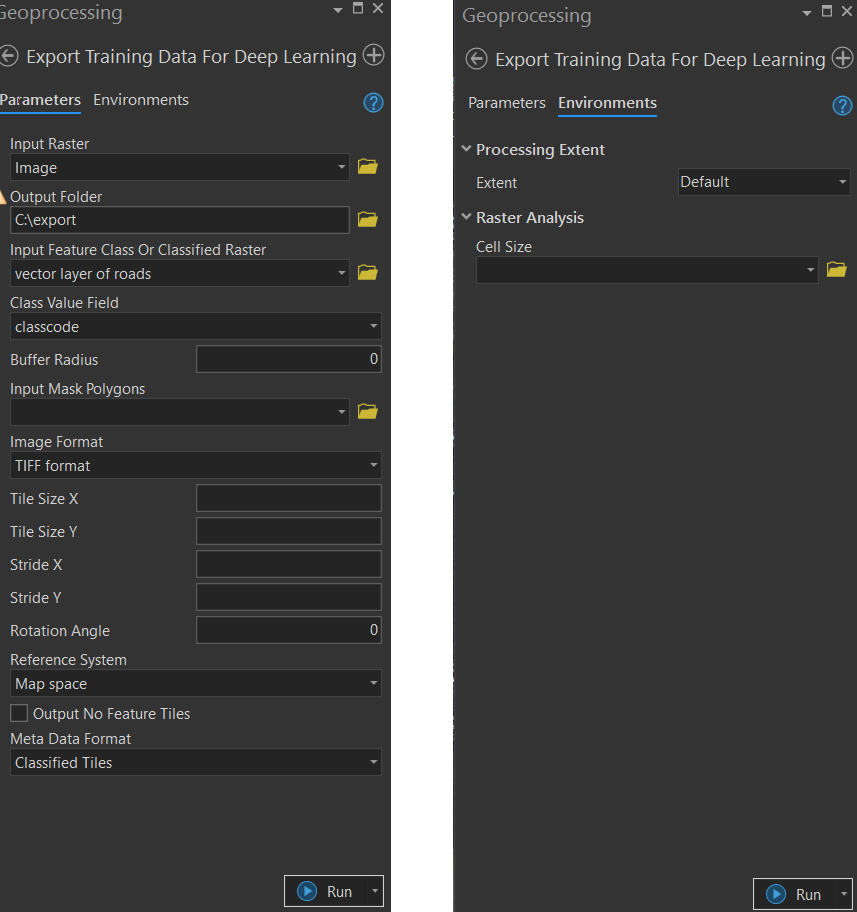
</p>


<center>Figure 2: Export Training Data For Deep Learning GP tool</center>

This tool will create all the necessary files needed in the next step, at the Output Folder's directory.

## Data preparation

_**Imports:**_

In [ ]:
from arcgis.learn import prepare_data, MultiTaskRoadExtractor

_**Preparing the exported data:**_

_Some of the frequently used parameters that can be passed in `prepare_data()` are described below:_

`path`: the path of the folder containing training data. (Output generated by the "Export Training data for deep learning GP tool")

`chip_size`: Images are cropped to the specified chip_size.

`batch_size`: No. of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 

`val_split_pct`: Percentage of training data to keep as validation.

`resize_to`: Resize the cropped image to the mentioned size.

In [ ]:
output_path = r'path/to/exported/data/from/Pro-GP-tool'

In [ ]:
data = prepare_data(output_path, chip_size=512, batch_size=10)

In [ ]:
data.classes

_**Try it live:**_

Alternatively, this notebook can be 'tried' live. The following steps will download a sample 'exported data' and pass it to `prepare_data()`:

**Note:** _Data meant for 'Try it Live' is a very small subset of the actual data that was used for this sample notebook, so the training time, accuracy, visualization, etc. will change, from what is depicted below._

In [ ]:
import os, zipfile
from pathlib import Path
from arcgis.gis import GIS
gis = GIS('home')

<Item title:"automatic_road_extraction_using_deep_learning" type:Image Collection owner:api_data_owner>
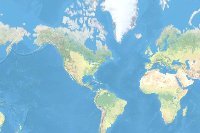

In [ ]:
training_data = gis.content.get('b7bbf2f5f4184960890afeabbdb51a32')
training_data

In [ ]:
filepath = training_data.download(file_name=training_data.name)

In [ ]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [ ]:
output_path = Path(os.path.join(filepath.split('.')[0]))

In [ ]:
data = prepare_data(output_path, chip_size=512, batch_size=10)

In [ ]:
data.classes

## Visualization of prepared data

`show_batch()` can be used to show the prepared data. Where input imagery is shown with labels overlayed on them. 

`alpha` is used to control the transparency of labels.

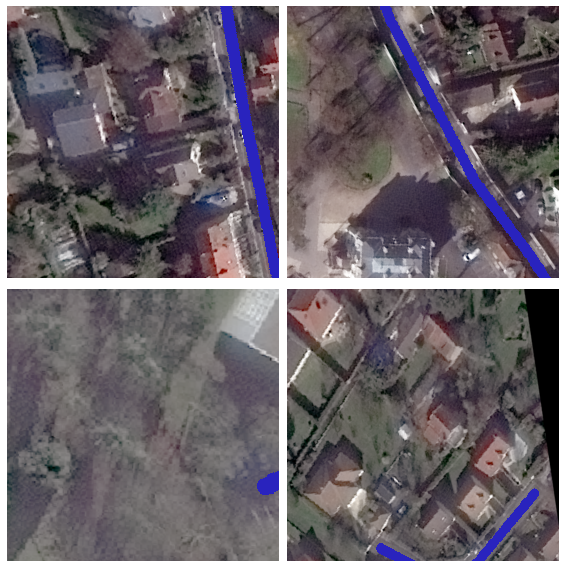

In [ ]:
data.show_batch(alpha=1)

## Training the model

First, the Multi-Task Road Extractor model object is created, utilizing the prepared data. Some model-specific advance parameters can be set at this stage.

**All of these parameters are optional, as smart 'default values' are already set, which works best in most cases.**

_The advance parameters are described below:_

- `gaussian_thresh`: sets the gaussian threshold which allows setting the required road width.


- `orient_bin_size`: sets the bin size for orientation angles.


- `orient_theta`: sets the width of the orientation mask.


- `mtl_model`: It defines two different architectures used to train the Multi-Task Extractor. Values are "linknet" and "hourglass".

While, backbones only work with 'linknet' architecture.
_('resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152' are the supported backbones.)_

In [ ]:
model = MultiTaskRoadExtractor(data, mtl_model="hourglass")

Next, `lr_find()` function is used to find the optimal learning rate. It controls the rate at which existing information will be overwritten by newly acquired information throughout the training process. If no value is specified, the optimal learning rate will be extracted from the learning curve during the training process.

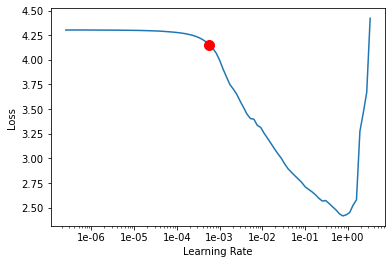

0.0005754399373371565

In [ ]:
model.lr_find()

`fit()` is used to train the model, where a new 'optimum learning rate' is automatically computed or the previously computed optimum learning rate can be passed. <i>(Any other user-defined learning rate can also be passed)</i>

If `early_stopping` is True, then the model training will stop when the model is no longer improving, regardless of the `epochs` parameter value specified. While an 'epoch' means the dataset will be passed forward and backward through the neural network one time.

`miou` and `dice` are the performance metrics, shown after completion of each epoch.

In [ ]:
model.fit(50, 0.0005754399373371565, early_stopping=True)

epoch,train_loss,valid_loss,accuracy,miou,dice,time
0,0.548448,0.539585,0.955007,0.813954,0.742421,1:36:12
1,0.388270,0.398783,0.964153,0.844706,0.781793,1:35:36
2,0.266606,0.292986,0.975121,0.891181,0.854522,1:35:52
3,0.221755,0.238013,0.981758,0.920282,0.893703,1:35:08
4,0.183346,0.205614,0.985037,0.933706,0.909582,1:35:14
5,0.157644,0.177976,0.987664,0.945289,0.925815,1:36:11
6,0.142403,0.179048,0.986943,0.941960,0.917824,1:36:39
7,0.125207,0.175523,0.987328,0.943237,0.917360,1:35:14
8,0.117216,0.149206,0.989932,0.954738,0.934074,1:36:27
9,0.118672,0.152716,0.988726,0.949733,0.931475,1:36:10


Epoch 21: early stopping


## Visualization of results

`show_results()` is used to visualize the results of the model, for the same scene with the ground truth. 
Validation data is used for this.

- 1<sup>st</sup> column is the _**'ground truth image'**_ overlayed with its corresponding _**'ground truth labels'**_.


- 2<sup>nd</sup> column is the _**'ground truth image'**_ overlayed with its corresponding _**'predicted labels'**_.

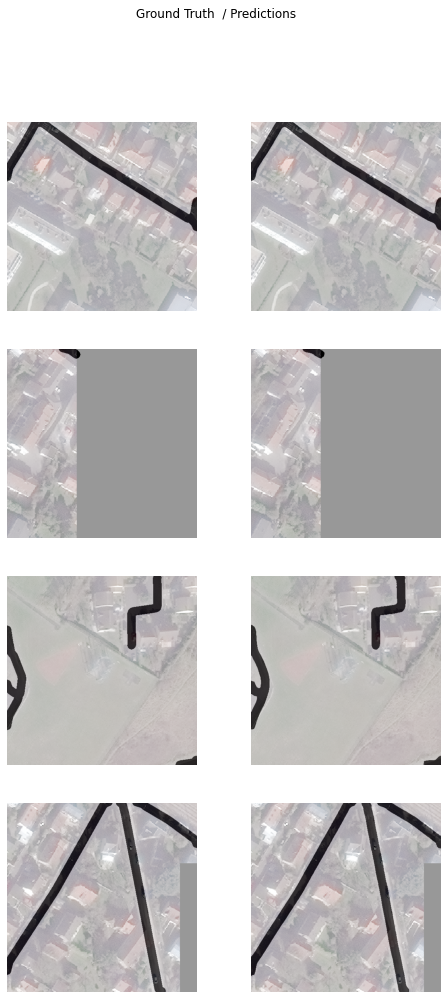

In [ ]:
model.show_results(rows=4)

## Saving the trained model

The last step, related to training, is saving the model using `save()`. Here apart from model files, performance metrics, a graph of validation and training losses, sample results, etc are also saved.

In [ ]:
model.save('road_model_for_spacenet_data')

WindowsPath('models/road_model_for_spacenet_data')

## Inference using the trained model, in ArcGIS Pro

The model saved in the previous step can be used to extract a classified  raster using  <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm" target="_blank">Classify Pixels Using Deep Learning tool</a> <i>(As shown in Figure. 3)</i>.

Further, the classified raster can be converted into a vector road layer in ArcGIS Pro. The regularisation related GP tools can be used to remove unwanted artifacts in the output. As the model was trained on a `Cell Size` of '30 cm', at this step too, the `Cell Size` is kept equal to '30 cm'. 

<p align="center">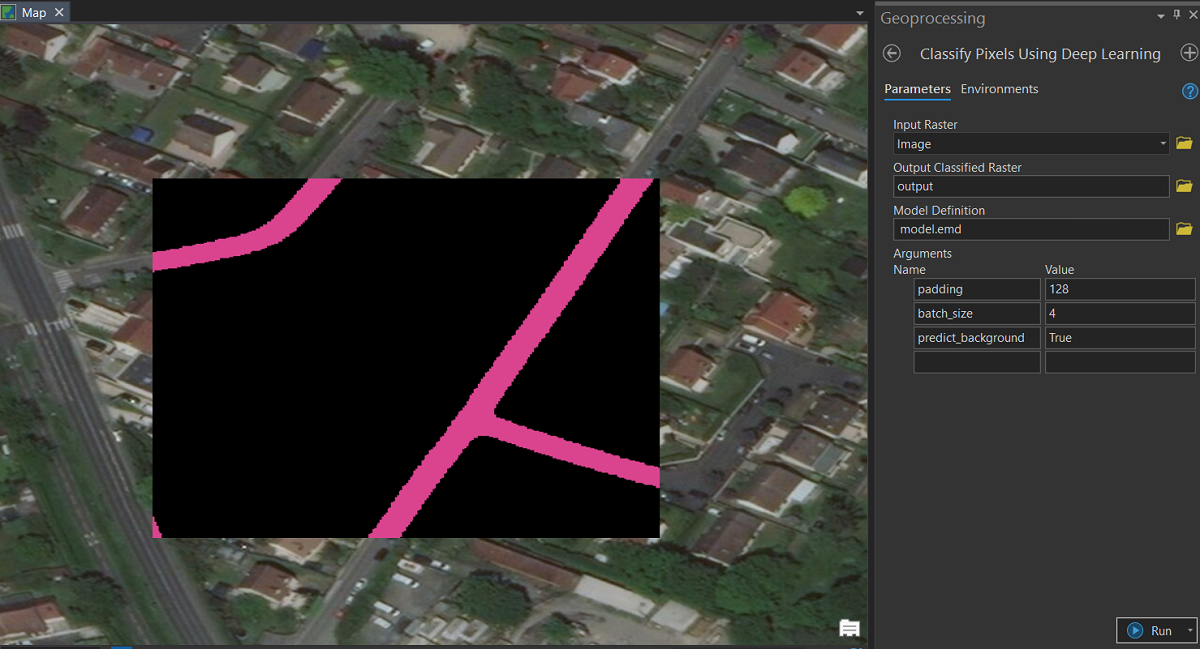
</p>

<center>Figure 3: Classify Pixels Using Deep Learning tool</center>

## Conclusion

This notebook has summarized the end-to-end workflow for the training of a deep learning model for road classification. This type of model can predict the roads occluded by small and medium length shadows, however when roads have larger occlusions from clouds/shadows then it is unable to create connected road networks.

## References

- The SpaceNet dataset used in this sample notebook is licensed under the <a href="http://creativecommons.org/licenses/by-sa/4.0/" target="_blank">Creative Commons Attribution-ShareAlike 4.0 International License</a>.